In [1]:
# Choose which feature to predict:
features_out = ["prod_wind", "prod_solar"]

In [28]:
import os
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import IPython
import IPython.display


sns.set_theme()

In [4]:
df = pd.read_pickle("..\data\data_prepared.pkl")
df.head()

,prod_wind,prod_solar,day_sin,day_cos,year_sin,year_cos,solar_el,solar_el_clip
datetime,,,,,,,,
2020-01-01 00:00:00+00:00,6989.50,0.0,-7.670342e-12,1.000000,-2.150345e-03,0.999998,-60.949049,0.0
2020-01-01 01:00:00+00:00,7371.25,0.0,2.588190e-01,0.965926,-1.433564e-03,0.999999,-56.073363,0.0
2020-01-01 02:00:00+00:00,7447.75,0.0,5.000000e-01,0.866025,-7.167823e-04,1.000000,-48.553549,0.0
2020-01-01 03:00:00+00:00,7699.25,0.0,7.071068e-01,0.707107,1.964387e-15,1.000000,-39.725411,0.0
2020-01-01 04:00:00+00:00,7703.00,0.0,8.660254e-01,0.500000,7.167823e-04,1.000000,-30.389395,0.0


In [5]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
df_train = df[0:int(n*0.7)]
df_val = df[int(n*0.7):int(n*0.9)]
df_test = df[int(n*0.9):]

num_features = len(features_out)

In [6]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
# fit scaler to training data
scaler.fit(df_train)
# scale all sets according to train set, preserve data frames
df_train = pd.DataFrame(scaler.transform(df_train),
                        columns=df.columns, index=df_train.index)
df_val = pd.DataFrame(scaler.transform(df_val),
                        columns=df.columns, index=df_val.index)
df_test = pd.DataFrame(scaler.transform(df_test),
                        columns=df.columns, index=df_test.index)

In [7]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=df_train, val_df=df_val, test_df=df_test,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [8]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [9]:
def plot(self, model=None, plot_col="prod_solar", max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=3)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        # Add last point of input array to label and prediction arrays to connect lines
        label_indices_plot = np.insert(
            self.label_indices, 0, self.input_indices[-1])
        labels_plot = np.insert(
            labels[n, :, label_col_index], 0, inputs[n, :, plot_col_index][-1])

        plt.plot(label_indices_plot, labels_plot, 'C2',
                 label='Labels', marker='.', zorder=1)
        if model is not None:
            predictions_plot = (model(inputs))[n, :, label_col_index]
            predictions_plot = np.insert(
                predictions_plot, 0, inputs[n, :, plot_col_index][-1])
            plt.plot(label_indices_plot, predictions_plot,
                     'C1', label='Predictions', marker='.', zorder=2)

        if n == 0:
            plt.legend()

    plt.xlabel('Time [h]')


WindowGenerator.plot = plot

In [10]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [11]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.test` dataset
    result = next(iter(self.test))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): ['prod_wind', 'prod_solar']

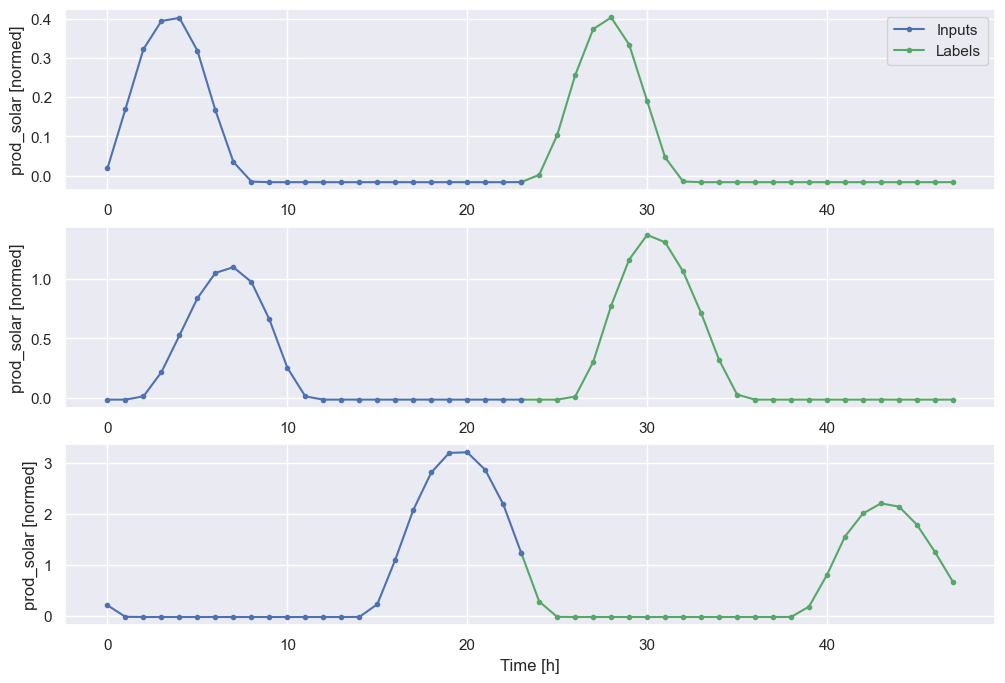

In [12]:
IN_STEPS = 24
OUT_STEPS = 24

multi_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=IN_STEPS, label_width=OUT_STEPS, shift=OUT_STEPS,
    label_columns=features_out)

multi_window.plot()
multi_window

In [23]:
MAX_EPOCHS = 5


def compile_and_fit(model, window, patience=4):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min',
                                                      verbose=1)

    model.compile(loss='mse', optimizer='adam', metrics=['mae', RSquare()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    return history

In [24]:
def build_model(params):
    lstm_model = tf.keras.Sequential([
        # Shape [batch, time, features] => [batch, lstm_units].
        # Adding more `lstm_units` just overfits more quickly.
        tf.keras.layers.LSTM(params['n_unit'], return_sequences=False),
        # Shape => [batch, out_steps*features].
        tf.keras.layers.Dense(OUT_STEPS*num_features,
                            kernel_initializer=tf.initializers.zeros()),
        # Shape => [batch, out_steps, features].
        tf.keras.layers.Reshape([OUT_STEPS, num_features])
    ])
    return lstm_model

  1/109 [..............................] - ETA: 4s - loss: 0.0995 - mae: 0.2170 - r_square: 0.7466

109/109 [==============================] - 0s 2ms/step - loss: 0.1011 - mae: 0.2157 - r_square: 0.7213


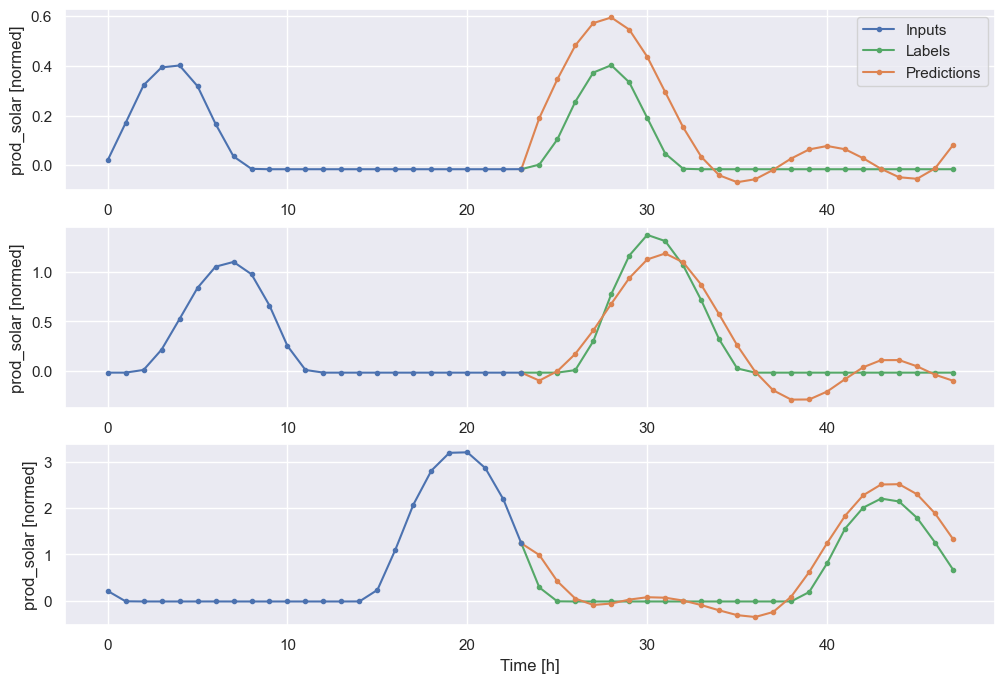

In [25]:
from tensorflow_addons.metrics.r_square import RSquare
lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(lstm_model, multi_window)

IPython.display.clear_output()

val_performance = {}
test_performance = {}

val_performance['LSTM'] = lstm_model.evaluate(multi_window.val)
test_performance['LSTM'] = lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(lstm_model)

In [26]:
import optuna as optuna
def objective(trial):

    params = {
              'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
              'optimizer': trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"]),
              'n_unit': trial.suggest_int("n_unit", 4, 18)
              }
    
    model = build_model(params)
    history = compile_and_fit(model, multi_window)
    
    accuracy = lstm_model.evaluate(multi_window.test, verbose=0)

    return accuracy[1]

In [27]:
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=30)

[I 2022-10-12 11:21:24,653] A new study created in memory with name: no-name-189b8b7a-a409-4931-b2ad-de3f0cf555e2


Epoch 1/5


C:\Users\Dilara\AppData\Local\Temp\ipykernel_23228\92306806.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),


383/383 [==============================] - 5s 7ms/step - loss: 0.4678 - mae: 0.4850 - r_square: 0.3324 - val_loss: 0.3086 - val_mae: 0.4141 - val_r_square: 0.4318
Epoch 2/5
383/383 [==============================] - 3s 7ms/step - loss: 0.2259 - mae: 0.3640 - r_square: 0.6370 - val_loss: 0.2129 - val_mae: 0.3502 - val_r_square: 0.5766
Epoch 3/5
383/383 [==============================] - 2s 6ms/step - loss: 0.1926 - mae: 0.3362 - r_square: 0.6823 - val_loss: 0.1805 - val_mae: 0.3201 - val_r_square: 0.6263
Epoch 4/5
383/383 [==============================] - 2s 6ms/step - loss: 0.1732 - mae: 0.3155 - r_square: 0.7077 - val_loss: 0.1567 - val_mae: 0.2932 - val_r_square: 0.6555
Epoch 5/5
383/383 [==============================] - 2s 6ms/step - loss: 0.1562 - mae: 0.2933 - r_square: 0.7286 - val_loss: 0.1321 - val_mae: 0.2631 - val_r_square: 0.6810


[I 2022-10-12 11:21:39,368] Trial 0 finished with value: 0.2435956746339798 and parameters: {'learning_rate': 0.0004323188285585945, 'optimizer': 'Adam', 'n_unit': 10}. Best is trial 0 with value: 0.2435956746339798.


Epoch 1/5
383/383 [==============================] - 4s 7ms/step - loss: 0.4491 - mae: 0.4695 - r_square: 0.3551 - val_loss: 0.2860 - val_mae: 0.3962 - val_r_square: 0.4951
Epoch 2/5
383/383 [==============================] - 2s 6ms/step - loss: 0.2165 - mae: 0.3555 - r_square: 0.6527 - val_loss: 0.2020 - val_mae: 0.3403 - val_r_square: 0.6123
Epoch 3/5
383/383 [==============================] - 2s 6ms/step - loss: 0.1873 - mae: 0.3303 - r_square: 0.6919 - val_loss: 0.1719 - val_mae: 0.3140 - val_r_square: 0.6443
Epoch 4/5
383/383 [==============================] - 2s 6ms/step - loss: 0.1672 - mae: 0.3068 - r_square: 0.7166 - val_loss: 0.1440 - val_mae: 0.2818 - val_r_square: 0.6693
Epoch 5/5
383/383 [==============================] - 2s 6ms/step - loss: 0.1500 - mae: 0.2839 - r_square: 0.7371 - val_loss: 0.1232 - val_mae: 0.2546 - val_r_square: 0.6909


[I 2022-10-12 11:21:53,539] Trial 1 finished with value: 0.24359573423862457 and parameters: {'learning_rate': 0.0004583896363079125, 'optimizer': 'RMSprop', 'n_unit': 11}. Best is trial 0 with value: 0.2435956746339798.


Epoch 1/5
383/383 [==============================] - 5s 7ms/step - loss: 0.3931 - mae: 0.4440 - r_square: 0.4252 - val_loss: 0.2119 - val_mae: 0.3455 - val_r_square: 0.5872
Epoch 2/5
383/383 [==============================] - 2s 6ms/step - loss: 0.1854 - mae: 0.3298 - r_square: 0.6901 - val_loss: 0.1514 - val_mae: 0.2849 - val_r_square: 0.6615
Epoch 3/5
383/383 [==============================] - 3s 7ms/step - loss: 0.1516 - mae: 0.2862 - r_square: 0.7327 - val_loss: 0.1222 - val_mae: 0.2454 - val_r_square: 0.6936
Epoch 4/5
383/383 [==============================] - 2s 6ms/step - loss: 0.1377 - mae: 0.2635 - r_square: 0.7510 - val_loss: 0.1122 - val_mae: 0.2308 - val_r_square: 0.7065
Epoch 5/5
383/383 [==============================] - 3s 7ms/step - loss: 0.1315 - mae: 0.2535 - r_square: 0.7599 - val_loss: 0.1066 - val_mae: 0.2226 - val_r_square: 0.7145


[I 2022-10-12 11:22:09,143] Trial 2 finished with value: 0.24359571933746338 and parameters: {'learning_rate': 0.033623869643613066, 'optimizer': 'RMSprop', 'n_unit': 18}. Best is trial 0 with value: 0.2435956746339798.


Epoch 1/5
383/383 [==============================] - 6s 8ms/step - loss: 0.4325 - mae: 0.4671 - r_square: 0.3792 - val_loss: 0.2504 - val_mae: 0.3625 - val_r_square: 0.5582
Epoch 2/5
383/383 [==============================] - 2s 6ms/step - loss: 0.1993 - mae: 0.3430 - r_square: 0.6749 - val_loss: 0.1740 - val_mae: 0.3175 - val_r_square: 0.6355
Epoch 3/5
383/383 [==============================] - 3s 7ms/step - loss: 0.1627 - mae: 0.3032 - r_square: 0.7210 - val_loss: 0.1303 - val_mae: 0.2618 - val_r_square: 0.6756
Epoch 4/5
383/383 [==============================] - 2s 6ms/step - loss: 0.1408 - mae: 0.2687 - r_square: 0.7477 - val_loss: 0.1183 - val_mae: 0.2459 - val_r_square: 0.6872
Epoch 5/5
383/383 [==============================] - 2s 6ms/step - loss: 0.1336 - mae: 0.2571 - r_square: 0.7580 - val_loss: 0.1113 - val_mae: 0.2334 - val_r_square: 0.7046


[I 2022-10-12 11:22:24,975] Trial 3 finished with value: 0.24359571933746338 and parameters: {'learning_rate': 0.0008439019608331386, 'optimizer': 'Adam', 'n_unit': 15}. Best is trial 0 with value: 0.2435956746339798.


Epoch 1/5
383/383 [==============================] - 5s 9ms/step - loss: 0.4224 - mae: 0.4638 - r_square: 0.3966 - val_loss: 0.2462 - val_mae: 0.3657 - val_r_square: 0.5491
Epoch 2/5
383/383 [==============================] - 3s 7ms/step - loss: 0.1977 - mae: 0.3414 - r_square: 0.6777 - val_loss: 0.1830 - val_mae: 0.3231 - val_r_square: 0.6323
Epoch 3/5
383/383 [==============================] - 2s 6ms/step - loss: 0.1691 - mae: 0.3109 - r_square: 0.7143 - val_loss: 0.1458 - val_mae: 0.2780 - val_r_square: 0.6679
Epoch 4/5
383/383 [==============================] - 2s 6ms/step - loss: 0.1454 - mae: 0.2768 - r_square: 0.7425 - val_loss: 0.1232 - val_mae: 0.2501 - val_r_square: 0.6890
Epoch 5/5
383/383 [==============================] - 2s 6ms/step - loss: 0.1360 - mae: 0.2614 - r_square: 0.7549 - val_loss: 0.1162 - val_mae: 0.2413 - val_r_square: 0.7000


[I 2022-10-12 11:22:39,983] Trial 4 finished with value: 0.24359573423862457 and parameters: {'learning_rate': 0.00023805603193830476, 'optimizer': 'RMSprop', 'n_unit': 15}. Best is trial 0 with value: 0.2435956746339798.


Epoch 1/5
383/383 [==============================] - 4s 7ms/step - loss: 0.4198 - mae: 0.4643 - r_square: 0.3955 - val_loss: 0.2302 - val_mae: 0.3604 - val_r_square: 0.5593
Epoch 2/5
383/383 [==============================] - 2s 6ms/step - loss: 0.1892 - mae: 0.3329 - r_square: 0.6867 - val_loss: 0.1591 - val_mae: 0.2998 - val_r_square: 0.6483
Epoch 3/5
383/383 [==============================] - 2s 6ms/step - loss: 0.1535 - mae: 0.2881 - r_square: 0.7310 - val_loss: 0.1239 - val_mae: 0.2538 - val_r_square: 0.6887
Epoch 4/5
383/383 [==============================] - 2s 6ms/step - loss: 0.1378 - mae: 0.2635 - r_square: 0.7516 - val_loss: 0.1151 - val_mae: 0.2415 - val_r_square: 0.7022
Epoch 5/5
383/383 [==============================] - 2s 6ms/step - loss: 0.1323 - mae: 0.2548 - r_square: 0.7599 - val_loss: 0.1099 - val_mae: 0.2328 - val_r_square: 0.7128


[I 2022-10-12 11:22:53,384] Trial 5 finished with value: 0.24359571933746338 and parameters: {'learning_rate': 0.07035969394067751, 'optimizer': 'SGD', 'n_unit': 16}. Best is trial 0 with value: 0.2435956746339798.


Epoch 1/5
383/383 [==============================] - 4s 7ms/step - loss: 0.5101 - mae: 0.4999 - r_square: 0.2772 - val_loss: 0.3677 - val_mae: 0.4388 - val_r_square: 0.4418
Epoch 2/5
383/383 [==============================] - 2s 6ms/step - loss: 0.2446 - mae: 0.3705 - r_square: 0.6208 - val_loss: 0.2316 - val_mae: 0.3530 - val_r_square: 0.5881
Epoch 3/5
383/383 [==============================] - 2s 6ms/step - loss: 0.2029 - mae: 0.3421 - r_square: 0.6750 - val_loss: 0.2006 - val_mae: 0.3331 - val_r_square: 0.6243
Epoch 4/5
383/383 [==============================] - 2s 6ms/step - loss: 0.1869 - mae: 0.3281 - r_square: 0.6958 - val_loss: 0.1780 - val_mae: 0.3156 - val_r_square: 0.6452
Epoch 5/5
383/383 [==============================] - 2s 6ms/step - loss: 0.1704 - mae: 0.3113 - r_square: 0.7156 - val_loss: 0.1524 - val_mae: 0.2882 - val_r_square: 0.6687


[I 2022-10-12 11:23:07,764] Trial 6 finished with value: 0.24359571933746338 and parameters: {'learning_rate': 1.2832320656517343e-05, 'optimizer': 'RMSprop', 'n_unit': 9}. Best is trial 0 with value: 0.2435956746339798.


Epoch 1/5
383/383 [==============================] - 4s 7ms/step - loss: 0.6319 - mae: 0.5413 - r_square: 0.1221 - val_loss: 0.6075 - val_mae: 0.5770 - val_r_square: 0.0542
Epoch 2/5
383/383 [==============================] - 2s 6ms/step - loss: 0.3495 - mae: 0.4420 - r_square: 0.4767 - val_loss: 0.3300 - val_mae: 0.4233 - val_r_square: 0.3954
Epoch 3/5
383/383 [==============================] - 2s 6ms/step - loss: 0.2491 - mae: 0.3783 - r_square: 0.6089 - val_loss: 0.2553 - val_mae: 0.3734 - val_r_square: 0.5322
Epoch 4/5
383/383 [==============================] - 2s 6ms/step - loss: 0.2190 - mae: 0.3556 - r_square: 0.6523 - val_loss: 0.2249 - val_mae: 0.3531 - val_r_square: 0.5840
Epoch 5/5
383/383 [==============================] - 2s 6ms/step - loss: 0.2053 - mae: 0.3442 - r_square: 0.6721 - val_loss: 0.2090 - val_mae: 0.3417 - val_r_square: 0.6121


[I 2022-10-12 11:23:21,998] Trial 7 finished with value: 0.243595689535141 and parameters: {'learning_rate': 0.019586695929446323, 'optimizer': 'Adam', 'n_unit': 4}. Best is trial 0 with value: 0.2435956746339798.


Epoch 1/5
383/383 [==============================] - 5s 7ms/step - loss: 0.4651 - mae: 0.4834 - r_square: 0.3373 - val_loss: 0.3085 - val_mae: 0.4036 - val_r_square: 0.4883
Epoch 2/5
383/383 [==============================] - 2s 6ms/step - loss: 0.2262 - mae: 0.3610 - r_square: 0.6415 - val_loss: 0.2145 - val_mae: 0.3435 - val_r_square: 0.6035
Epoch 3/5
383/383 [==============================] - 2s 6ms/step - loss: 0.1964 - mae: 0.3385 - r_square: 0.6819 - val_loss: 0.1875 - val_mae: 0.3224 - val_r_square: 0.6402
Epoch 4/5
383/383 [==============================] - 2s 6ms/step - loss: 0.1808 - mae: 0.3234 - r_square: 0.7022 - val_loss: 0.1623 - val_mae: 0.2978 - val_r_square: 0.6630
Epoch 5/5
383/383 [==============================] - 2s 6ms/step - loss: 0.1613 - mae: 0.2999 - r_square: 0.7246 - val_loss: 0.1327 - val_mae: 0.2654 - val_r_square: 0.6832


[I 2022-10-12 11:23:36,436] Trial 8 finished with value: 0.24359573423862457 and parameters: {'learning_rate': 0.003437845679792193, 'optimizer': 'Adam', 'n_unit': 10}. Best is trial 0 with value: 0.2435956746339798.


Epoch 1/5
383/383 [==============================] - 4s 7ms/step - loss: 0.4150 - mae: 0.4612 - r_square: 0.4004 - val_loss: 0.2352 - val_mae: 0.3603 - val_r_square: 0.5625
Epoch 2/5
383/383 [==============================] - 2s 6ms/step - loss: 0.1955 - mae: 0.3394 - r_square: 0.6802 - val_loss: 0.1719 - val_mae: 0.3098 - val_r_square: 0.6504
Epoch 3/5
383/383 [==============================] - 2s 6ms/step - loss: 0.1579 - mae: 0.2952 - r_square: 0.7266 - val_loss: 0.1216 - val_mae: 0.2494 - val_r_square: 0.6951
Epoch 4/5
383/383 [==============================] - 2s 6ms/step - loss: 0.1374 - mae: 0.2628 - r_square: 0.7522 - val_loss: 0.1105 - val_mae: 0.2320 - val_r_square: 0.7125
Epoch 5/5
383/383 [==============================] - 2s 6ms/step - loss: 0.1310 - mae: 0.2528 - r_square: 0.7614 - val_loss: 0.1074 - val_mae: 0.2268 - val_r_square: 0.7189


[I 2022-10-12 11:23:51,081] Trial 9 finished with value: 0.24359573423862457 and parameters: {'learning_rate': 0.011042215629510887, 'optimizer': 'SGD', 'n_unit': 17}. Best is trial 0 with value: 0.2435956746339798.


Epoch 1/5
383/383 [==============================] - 4s 7ms/step - loss: 0.6198 - mae: 0.5709 - r_square: 0.1420 - val_loss: 0.7286 - val_mae: 0.6279 - val_r_square: 0.1463
Epoch 2/5
383/383 [==============================] - 2s 6ms/step - loss: 0.4339 - mae: 0.4849 - r_square: 0.4112 - val_loss: 0.4674 - val_mae: 0.4896 - val_r_square: 0.3907
Epoch 3/5
383/383 [==============================] - 2s 6ms/step - loss: 0.2745 - mae: 0.3880 - r_square: 0.5907 - val_loss: 0.2681 - val_mae: 0.3777 - val_r_square: 0.5451
Epoch 4/5
383/383 [==============================] - 2s 6ms/step - loss: 0.2148 - mae: 0.3494 - r_square: 0.6605 - val_loss: 0.2200 - val_mae: 0.3473 - val_r_square: 0.6040
Epoch 5/5
383/383 [==============================] - 2s 6ms/step - loss: 0.1988 - mae: 0.3372 - r_square: 0.6811 - val_loss: 0.2018 - val_mae: 0.3353 - val_r_square: 0.6253


[I 2022-10-12 11:24:04,948] Trial 10 finished with value: 0.24359571933746338 and parameters: {'learning_rate': 5.1646645634982956e-05, 'optimizer': 'Adam', 'n_unit': 6}. Best is trial 0 with value: 0.2435956746339798.


Epoch 1/5
383/383 [==============================] - 4s 7ms/step - loss: 0.6545 - mae: 0.5719 - r_square: 0.0857 - val_loss: 0.7312 - val_mae: 0.6287 - val_r_square: 0.1516
Epoch 2/5
383/383 [==============================] - 2s 6ms/step - loss: 0.5066 - mae: 0.5261 - r_square: 0.3268 - val_loss: 0.6610 - val_mae: 0.5860 - val_r_square: 0.2568
Epoch 3/5
383/383 [==============================] - 2s 6ms/step - loss: 0.3958 - mae: 0.4580 - r_square: 0.4581 - val_loss: 0.4312 - val_mae: 0.4658 - val_r_square: 0.4107
Epoch 4/5
383/383 [==============================] - 2s 6ms/step - loss: 0.2814 - mae: 0.3898 - r_square: 0.5826 - val_loss: 0.2912 - val_mae: 0.3857 - val_r_square: 0.5235
Epoch 5/5
383/383 [==============================] - 2s 6ms/step - loss: 0.2287 - mae: 0.3594 - r_square: 0.6431 - val_loss: 0.2366 - val_mae: 0.3567 - val_r_square: 0.5788


[I 2022-10-12 11:24:18,398] Trial 11 finished with value: 0.24359571933746338 and parameters: {'learning_rate': 0.00537391352411717, 'optimizer': 'Adam', 'n_unit': 4}. Best is trial 0 with value: 0.2435956746339798.


Epoch 1/5
383/383 [==============================] - 4s 7ms/step - loss: 0.5633 - mae: 0.5367 - r_square: 0.2175 - val_loss: 0.5622 - val_mae: 0.5531 - val_r_square: 0.2867
Epoch 2/5
383/383 [==============================] - 2s 6ms/step - loss: 0.3467 - mae: 0.4302 - r_square: 0.5083 - val_loss: 0.3083 - val_mae: 0.4077 - val_r_square: 0.4754
Epoch 3/5
383/383 [==============================] - 2s 6ms/step - loss: 0.2204 - mae: 0.3557 - r_square: 0.6496 - val_loss: 0.2158 - val_mae: 0.3480 - val_r_square: 0.5895
Epoch 4/5
383/383 [==============================] - 2s 6ms/step - loss: 0.1957 - mae: 0.3375 - r_square: 0.6828 - val_loss: 0.1902 - val_mae: 0.3306 - val_r_square: 0.6223
Epoch 5/5
383/383 [==============================] - 2s 6ms/step - loss: 0.1828 - mae: 0.3249 - r_square: 0.6995 - val_loss: 0.1728 - val_mae: 0.3136 - val_r_square: 0.6437


[I 2022-10-12 11:24:32,173] Trial 12 finished with value: 0.24359571933746338 and parameters: {'learning_rate': 0.00010481779125619557, 'optimizer': 'Adam', 'n_unit': 7}. Best is trial 0 with value: 0.2435956746339798.


Epoch 1/5
383/383 [==============================] - 5s 7ms/step - loss: 0.4326 - mae: 0.4630 - r_square: 0.3801 - val_loss: 0.2585 - val_mae: 0.3758 - val_r_square: 0.5310
Epoch 2/5
383/383 [==============================] - 3s 7ms/step - loss: 0.2042 - mae: 0.3460 - r_square: 0.6701 - val_loss: 0.1892 - val_mae: 0.3308 - val_r_square: 0.6244
Epoch 3/5
383/383 [==============================] - 3s 7ms/step - loss: 0.1715 - mae: 0.3125 - r_square: 0.7121 - val_loss: 0.1451 - val_mae: 0.2802 - val_r_square: 0.6707
Epoch 4/5
383/383 [==============================] - 2s 6ms/step - loss: 0.1459 - mae: 0.2779 - r_square: 0.7429 - val_loss: 0.1221 - val_mae: 0.2507 - val_r_square: 0.6915
Epoch 5/5
383/383 [==============================] - 2s 6ms/step - loss: 0.1348 - mae: 0.2602 - r_square: 0.7572 - val_loss: 0.1138 - val_mae: 0.2393 - val_r_square: 0.7035


[I 2022-10-12 11:24:47,588] Trial 13 finished with value: 0.24359571933746338 and parameters: {'learning_rate': 0.0021735824793592397, 'optimizer': 'Adam', 'n_unit': 13}. Best is trial 0 with value: 0.2435956746339798.


Epoch 1/5
383/383 [==============================] - 5s 7ms/step - loss: 0.6448 - mae: 0.5709 - r_square: 0.1054 - val_loss: 0.7396 - val_mae: 0.6459 - val_r_square: 0.0979
Epoch 2/5
383/383 [==============================] - 2s 6ms/step - loss: 0.4912 - mae: 0.5215 - r_square: 0.3414 - val_loss: 0.6165 - val_mae: 0.5778 - val_r_square: 0.2370
Epoch 3/5
383/383 [==============================] - 2s 6ms/step - loss: 0.3914 - mae: 0.4573 - r_square: 0.4602 - val_loss: 0.4636 - val_mae: 0.4796 - val_r_square: 0.3951
Epoch 4/5
383/383 [==============================] - 2s 6ms/step - loss: 0.2906 - mae: 0.3921 - r_square: 0.5744 - val_loss: 0.2788 - val_mae: 0.3764 - val_r_square: 0.5311
Epoch 5/5
383/383 [==============================] - 2s 6ms/step - loss: 0.2231 - mae: 0.3559 - r_square: 0.6502 - val_loss: 0.2240 - val_mae: 0.3528 - val_r_square: 0.5876


[I 2022-10-12 11:25:01,462] Trial 14 finished with value: 0.2435956746339798 and parameters: {'learning_rate': 0.012026288066843015, 'optimizer': 'Adam', 'n_unit': 4}. Best is trial 0 with value: 0.2435956746339798.


Epoch 1/5
383/383 [==============================] - 4s 7ms/step - loss: 0.4932 - mae: 0.4865 - r_square: 0.2930 - val_loss: 0.3044 - val_mae: 0.4047 - val_r_square: 0.4588
Epoch 2/5
383/383 [==============================] - 2s 6ms/step - loss: 0.2294 - mae: 0.3659 - r_square: 0.6308 - val_loss: 0.2105 - val_mae: 0.3412 - val_r_square: 0.5913
Epoch 3/5
383/383 [==============================] - 2s 6ms/step - loss: 0.1909 - mae: 0.3317 - r_square: 0.6838 - val_loss: 0.1764 - val_mae: 0.3111 - val_r_square: 0.6361
Epoch 4/5
383/383 [==============================] - 2s 6ms/step - loss: 0.1723 - mae: 0.3102 - r_square: 0.7085 - val_loss: 0.1569 - val_mae: 0.2922 - val_r_square: 0.6598
Epoch 5/5
383/383 [==============================] - 2s 6ms/step - loss: 0.1593 - mae: 0.2943 - r_square: 0.7248 - val_loss: 0.1394 - val_mae: 0.2725 - val_r_square: 0.6778


[I 2022-10-12 11:25:15,123] Trial 15 finished with value: 0.24359573423862457 and parameters: {'learning_rate': 0.0014865994460053825, 'optimizer': 'Adam', 'n_unit': 8}. Best is trial 0 with value: 0.2435956746339798.


Epoch 1/5
383/383 [==============================] - 4s 7ms/step - loss: 0.4286 - mae: 0.4601 - r_square: 0.3771 - val_loss: 0.2543 - val_mae: 0.3780 - val_r_square: 0.5095
Epoch 2/5
383/383 [==============================] - 2s 6ms/step - loss: 0.2125 - mae: 0.3568 - r_square: 0.6535 - val_loss: 0.1951 - val_mae: 0.3383 - val_r_square: 0.6066
Epoch 3/5
383/383 [==============================] - 2s 6ms/step - loss: 0.1846 - mae: 0.3291 - r_square: 0.6920 - val_loss: 0.1630 - val_mae: 0.3064 - val_r_square: 0.6458
Epoch 4/5
383/383 [==============================] - 2s 6ms/step - loss: 0.1626 - mae: 0.3008 - r_square: 0.7200 - val_loss: 0.1355 - val_mae: 0.2701 - val_r_square: 0.6780
Epoch 5/5
383/383 [==============================] - 2s 6ms/step - loss: 0.1450 - mae: 0.2752 - r_square: 0.7416 - val_loss: 0.1190 - val_mae: 0.2456 - val_r_square: 0.6954


[I 2022-10-12 11:25:29,075] Trial 16 finished with value: 0.24359571933746338 and parameters: {'learning_rate': 0.09219040200885326, 'optimizer': 'SGD', 'n_unit': 12}. Best is trial 0 with value: 0.2435956746339798.


Epoch 1/5
383/383 [==============================] - 4s 6ms/step - loss: 0.6105 - mae: 0.5534 - r_square: 0.1624 - val_loss: 0.6813 - val_mae: 0.6035 - val_r_square: 0.2133
Epoch 2/5
383/383 [==============================] - 2s 6ms/step - loss: 0.3779 - mae: 0.4493 - r_square: 0.4711 - val_loss: 0.3396 - val_mae: 0.4148 - val_r_square: 0.4634
Epoch 3/5
383/383 [==============================] - 2s 6ms/step - loss: 0.2362 - mae: 0.3659 - r_square: 0.6287 - val_loss: 0.2324 - val_mae: 0.3569 - val_r_square: 0.5678
Epoch 4/5
383/383 [==============================] - 2s 6ms/step - loss: 0.2067 - mae: 0.3472 - r_square: 0.6676 - val_loss: 0.2074 - val_mae: 0.3400 - val_r_square: 0.6073
Epoch 5/5
383/383 [==============================] - 2s 6ms/step - loss: 0.1949 - mae: 0.3373 - r_square: 0.6844 - val_loss: 0.1931 - val_mae: 0.3299 - val_r_square: 0.6277


[I 2022-10-12 11:25:43,122] Trial 17 finished with value: 0.2435956746339798 and parameters: {'learning_rate': 0.0076976841842864106, 'optimizer': 'Adam', 'n_unit': 6}. Best is trial 0 with value: 0.2435956746339798.


Epoch 1/5
383/383 [==============================] - 5s 7ms/step - loss: 0.6058 - mae: 0.5460 - r_square: 0.1515 - val_loss: 0.6057 - val_mae: 0.5794 - val_r_square: 0.1887
Epoch 2/5
383/383 [==============================] - 2s 6ms/step - loss: 0.3923 - mae: 0.4590 - r_square: 0.4466 - val_loss: 0.4206 - val_mae: 0.4657 - val_r_square: 0.3895
Epoch 3/5
383/383 [==============================] - 2s 6ms/step - loss: 0.2601 - mae: 0.3803 - r_square: 0.6003 - val_loss: 0.2575 - val_mae: 0.3761 - val_r_square: 0.5278
Epoch 4/5
383/383 [==============================] - 2s 6ms/step - loss: 0.2159 - mae: 0.3529 - r_square: 0.6560 - val_loss: 0.2221 - val_mae: 0.3536 - val_r_square: 0.5858
Epoch 5/5
383/383 [==============================] - 2s 6ms/step - loss: 0.2023 - mae: 0.3420 - r_square: 0.6756 - val_loss: 0.2071 - val_mae: 0.3426 - val_r_square: 0.6117


[I 2022-10-12 11:25:56,967] Trial 18 finished with value: 0.24359571933746338 and parameters: {'learning_rate': 0.00024155606632095248, 'optimizer': 'Adam', 'n_unit': 5}. Best is trial 0 with value: 0.2435956746339798.


Epoch 1/5
383/383 [==============================] - 4s 7ms/step - loss: 0.4867 - mae: 0.5028 - r_square: 0.3100 - val_loss: 0.3089 - val_mae: 0.4059 - val_r_square: 0.4696
Epoch 2/5
383/383 [==============================] - 2s 6ms/step - loss: 0.2085 - mae: 0.3494 - r_square: 0.6614 - val_loss: 0.1851 - val_mae: 0.3256 - val_r_square: 0.6161
Epoch 3/5
383/383 [==============================] - 2s 6ms/step - loss: 0.1731 - mae: 0.3159 - r_square: 0.7063 - val_loss: 0.1467 - val_mae: 0.2839 - val_r_square: 0.6611
Epoch 4/5
383/383 [==============================] - 2s 6ms/step - loss: 0.1497 - mae: 0.2836 - r_square: 0.7349 - val_loss: 0.1220 - val_mae: 0.2525 - val_r_square: 0.6893
Epoch 5/5
383/383 [==============================] - 2s 6ms/step - loss: 0.1385 - mae: 0.2658 - r_square: 0.7495 - val_loss: 0.1139 - val_mae: 0.2401 - val_r_square: 0.7018


[I 2022-10-12 11:26:10,741] Trial 19 finished with value: 0.24359576404094696 and parameters: {'learning_rate': 2.2282349860334623e-05, 'optimizer': 'SGD', 'n_unit': 13}. Best is trial 0 with value: 0.2435956746339798.


Epoch 1/5
383/383 [==============================] - 4s 7ms/step - loss: 0.5555 - mae: 0.5283 - r_square: 0.2341 - val_loss: 0.4898 - val_mae: 0.5093 - val_r_square: 0.3589
Epoch 2/5
383/383 [==============================] - 2s 6ms/step - loss: 0.2706 - mae: 0.3847 - r_square: 0.5939 - val_loss: 0.2423 - val_mae: 0.3604 - val_r_square: 0.5676
Epoch 3/5
383/383 [==============================] - 2s 6ms/step - loss: 0.2051 - mae: 0.3441 - r_square: 0.6724 - val_loss: 0.2048 - val_mae: 0.3383 - val_r_square: 0.6198
Epoch 4/5
383/383 [==============================] - 2s 6ms/step - loss: 0.1902 - mae: 0.3320 - r_square: 0.6925 - val_loss: 0.1878 - val_mae: 0.3249 - val_r_square: 0.6431
Epoch 5/5
383/383 [==============================] - 2s 6ms/step - loss: 0.1795 - mae: 0.3212 - r_square: 0.7064 - val_loss: 0.1723 - val_mae: 0.3081 - val_r_square: 0.6611


[I 2022-10-12 11:26:24,066] Trial 20 finished with value: 0.243595689535141 and parameters: {'learning_rate': 0.0008919865766903571, 'optimizer': 'Adam', 'n_unit': 8}. Best is trial 0 with value: 0.2435956746339798.


Epoch 1/5
383/383 [==============================] - 4s 7ms/step - loss: 0.5917 - mae: 0.5374 - r_square: 0.1638 - val_loss: 0.4930 - val_mae: 0.5220 - val_r_square: 0.2148
Epoch 2/5
383/383 [==============================] - 2s 6ms/step - loss: 0.3205 - mae: 0.4263 - r_square: 0.5122 - val_loss: 0.2973 - val_mae: 0.3938 - val_r_square: 0.4989
Epoch 3/5
383/383 [==============================] - 2s 6ms/step - loss: 0.2339 - mae: 0.3636 - r_square: 0.6359 - val_loss: 0.2409 - val_mae: 0.3566 - val_r_square: 0.5853
Epoch 4/5
383/383 [==============================] - 2s 6ms/step - loss: 0.2091 - mae: 0.3437 - r_square: 0.6704 - val_loss: 0.2180 - val_mae: 0.3418 - val_r_square: 0.6151
Epoch 5/5
383/383 [==============================] - 2s 6ms/step - loss: 0.1989 - mae: 0.3360 - r_square: 0.6841 - val_loss: 0.2074 - val_mae: 0.3348 - val_r_square: 0.6286


[I 2022-10-12 11:26:37,263] Trial 21 finished with value: 0.24359573423862457 and parameters: {'learning_rate': 0.007527030572361963, 'optimizer': 'Adam', 'n_unit': 5}. Best is trial 0 with value: 0.2435956746339798.


Epoch 1/5
383/383 [==============================] - 4s 7ms/step - loss: 0.5456 - mae: 0.5049 - r_square: 0.2307 - val_loss: 0.4067 - val_mae: 0.4567 - val_r_square: 0.3535
Epoch 2/5
383/383 [==============================] - 2s 6ms/step - loss: 0.2683 - mae: 0.3872 - r_square: 0.5855 - val_loss: 0.2561 - val_mae: 0.3740 - val_r_square: 0.5236
Epoch 3/5
383/383 [==============================] - 2s 6ms/step - loss: 0.2184 - mae: 0.3561 - r_square: 0.6501 - val_loss: 0.2167 - val_mae: 0.3489 - val_r_square: 0.5831
Epoch 4/5
383/383 [==============================] - 2s 6ms/step - loss: 0.2015 - mae: 0.3439 - r_square: 0.6740 - val_loss: 0.1984 - val_mae: 0.3361 - val_r_square: 0.6144
Epoch 5/5
383/383 [==============================] - 2s 6ms/step - loss: 0.1930 - mae: 0.3364 - r_square: 0.6865 - val_loss: 0.1897 - val_mae: 0.3306 - val_r_square: 0.6287


[I 2022-10-12 11:26:51,370] Trial 22 finished with value: 0.24359573423862457 and parameters: {'learning_rate': 0.015175559695423127, 'optimizer': 'Adam', 'n_unit': 6}. Best is trial 0 with value: 0.2435956746339798.


Epoch 1/5
383/383 [==============================] - 5s 7ms/step - loss: 0.5521 - mae: 0.5112 - r_square: 0.2259 - val_loss: 0.4294 - val_mae: 0.4819 - val_r_square: 0.3420
Epoch 2/5
383/383 [==============================] - 2s 6ms/step - loss: 0.2689 - mae: 0.3904 - r_square: 0.5840 - val_loss: 0.2483 - val_mae: 0.3719 - val_r_square: 0.5250
Epoch 3/5
383/383 [==============================] - 2s 6ms/step - loss: 0.2157 - mae: 0.3552 - r_square: 0.6523 - val_loss: 0.2096 - val_mae: 0.3458 - val_r_square: 0.5888
Epoch 4/5
383/383 [==============================] - 2s 6ms/step - loss: 0.1951 - mae: 0.3374 - r_square: 0.6813 - val_loss: 0.1870 - val_mae: 0.3242 - val_r_square: 0.6303
Epoch 5/5
383/383 [==============================] - 2s 6ms/step - loss: 0.1810 - mae: 0.3224 - r_square: 0.7007 - val_loss: 0.1700 - val_mae: 0.3113 - val_r_square: 0.6409


[I 2022-10-12 11:27:06,038] Trial 23 finished with value: 0.24359571933746338 and parameters: {'learning_rate': 0.003049381553309771, 'optimizer': 'Adam', 'n_unit': 7}. Best is trial 0 with value: 0.2435956746339798.


Epoch 1/5
383/383 [==============================] - 4s 7ms/step - loss: 0.5292 - mae: 0.5261 - r_square: 0.2522 - val_loss: 0.4819 - val_mae: 0.5072 - val_r_square: 0.3071
Epoch 2/5
383/383 [==============================] - 2s 6ms/step - loss: 0.2640 - mae: 0.3851 - r_square: 0.5947 - val_loss: 0.2260 - val_mae: 0.3586 - val_r_square: 0.5685
Epoch 3/5
383/383 [==============================] - 2s 6ms/step - loss: 0.2004 - mae: 0.3438 - r_square: 0.6758 - val_loss: 0.1954 - val_mae: 0.3385 - val_r_square: 0.6187
Epoch 4/5
383/383 [==============================] - 2s 6ms/step - loss: 0.1871 - mae: 0.3312 - r_square: 0.6951 - val_loss: 0.1808 - val_mae: 0.3240 - val_r_square: 0.6428
Epoch 5/5
383/383 [==============================] - 2s 6ms/step - loss: 0.1747 - mae: 0.3178 - r_square: 0.7109 - val_loss: 0.1602 - val_mae: 0.3036 - val_r_square: 0.6596


[I 2022-10-12 11:27:19,711] Trial 24 finished with value: 0.2435956746339798 and parameters: {'learning_rate': 0.02168436272577882, 'optimizer': 'Adam', 'n_unit': 10}. Best is trial 0 with value: 0.2435956746339798.


Epoch 1/5
383/383 [==============================] - 4s 7ms/step - loss: 0.6277 - mae: 0.5456 - r_square: 0.1285 - val_loss: 0.6106 - val_mae: 0.5843 - val_r_square: 0.1636
Epoch 2/5
383/383 [==============================] - 2s 6ms/step - loss: 0.3871 - mae: 0.4593 - r_square: 0.4453 - val_loss: 0.4097 - val_mae: 0.4697 - val_r_square: 0.3432
Epoch 3/5
383/383 [==============================] - 2s 6ms/step - loss: 0.2681 - mae: 0.3872 - r_square: 0.5872 - val_loss: 0.2711 - val_mae: 0.3891 - val_r_square: 0.4998
Epoch 4/5
383/383 [==============================] - 2s 6ms/step - loss: 0.2233 - mae: 0.3578 - r_square: 0.6451 - val_loss: 0.2316 - val_mae: 0.3631 - val_r_square: 0.5638
Epoch 5/5
383/383 [==============================] - 2s 6ms/step - loss: 0.2080 - mae: 0.3459 - r_square: 0.6667 - val_loss: 0.2131 - val_mae: 0.3494 - val_r_square: 0.5966


[I 2022-10-12 11:27:33,310] Trial 25 finished with value: 0.24359571933746338 and parameters: {'learning_rate': 0.040027501269507784, 'optimizer': 'Adam', 'n_unit': 4}. Best is trial 0 with value: 0.2435956746339798.


Epoch 1/5
383/383 [==============================] - 4s 7ms/step - loss: 0.5575 - mae: 0.5238 - r_square: 0.2135 - val_loss: 0.4926 - val_mae: 0.5181 - val_r_square: 0.2819
Epoch 2/5
383/383 [==============================] - 2s 6ms/step - loss: 0.2929 - mae: 0.4034 - r_square: 0.5599 - val_loss: 0.2787 - val_mae: 0.3821 - val_r_square: 0.5283
Epoch 3/5
383/383 [==============================] - 2s 6ms/step - loss: 0.2263 - mae: 0.3586 - r_square: 0.6442 - val_loss: 0.2273 - val_mae: 0.3519 - val_r_square: 0.5884
Epoch 4/5
383/383 [==============================] - 2s 6ms/step - loss: 0.2049 - mae: 0.3429 - r_square: 0.6723 - val_loss: 0.2041 - val_mae: 0.3379 - val_r_square: 0.6163
Epoch 5/5
383/383 [==============================] - 2s 6ms/step - loss: 0.1935 - mae: 0.3338 - r_square: 0.6876 - val_loss: 0.1891 - val_mae: 0.3267 - val_r_square: 0.6375


[I 2022-10-12 11:27:46,717] Trial 26 finished with value: 0.24359571933746338 and parameters: {'learning_rate': 0.005817923985670949, 'optimizer': 'Adam', 'n_unit': 6}. Best is trial 0 with value: 0.2435956746339798.


Epoch 1/5
383/383 [==============================] - 4s 7ms/step - loss: 0.4774 - mae: 0.4863 - r_square: 0.3208 - val_loss: 0.2945 - val_mae: 0.3963 - val_r_square: 0.4778
Epoch 2/5
383/383 [==============================] - 2s 6ms/step - loss: 0.2156 - mae: 0.3548 - r_square: 0.6512 - val_loss: 0.1955 - val_mae: 0.3359 - val_r_square: 0.6081
Epoch 3/5
383/383 [==============================] - 2s 6ms/step - loss: 0.1837 - mae: 0.3274 - r_square: 0.6944 - val_loss: 0.1638 - val_mae: 0.3064 - val_r_square: 0.6474
Epoch 4/5
383/383 [==============================] - 2s 6ms/step - loss: 0.1643 - mae: 0.3039 - r_square: 0.7186 - val_loss: 0.1383 - val_mae: 0.2745 - val_r_square: 0.6715
Epoch 5/5
383/383 [==============================] - 2s 6ms/step - loss: 0.1488 - mae: 0.2816 - r_square: 0.7371 - val_loss: 0.1248 - val_mae: 0.2548 - val_r_square: 0.6850


[I 2022-10-12 11:28:00,311] Trial 27 finished with value: 0.243595689535141 and parameters: {'learning_rate': 0.026955658902136366, 'optimizer': 'Adam', 'n_unit': 10}. Best is trial 0 with value: 0.2435956746339798.


Epoch 1/5
383/383 [==============================] - 5s 7ms/step - loss: 0.5004 - mae: 0.5098 - r_square: 0.2979 - val_loss: 0.3593 - val_mae: 0.4340 - val_r_square: 0.4467
Epoch 2/5
383/383 [==============================] - 2s 6ms/step - loss: 0.2264 - mae: 0.3623 - r_square: 0.6423 - val_loss: 0.2084 - val_mae: 0.3460 - val_r_square: 0.5982
Epoch 3/5
383/383 [==============================] - 2s 6ms/step - loss: 0.1892 - mae: 0.3325 - r_square: 0.6900 - val_loss: 0.1790 - val_mae: 0.3199 - val_r_square: 0.6351
Epoch 4/5
383/383 [==============================] - 2s 6ms/step - loss: 0.1725 - mae: 0.3139 - r_square: 0.7113 - val_loss: 0.1592 - val_mae: 0.3000 - val_r_square: 0.6540
Epoch 5/5
383/383 [==============================] - 2s 6ms/step - loss: 0.1579 - mae: 0.2954 - r_square: 0.7291 - val_loss: 0.1401 - val_mae: 0.2748 - val_r_square: 0.6727


[I 2022-10-12 11:28:14,673] Trial 28 finished with value: 0.24359579384326935 and parameters: {'learning_rate': 0.0004979224456617429, 'optimizer': 'RMSprop', 'n_unit': 11}. Best is trial 0 with value: 0.2435956746339798.


Epoch 1/5
383/383 [==============================] - 5s 7ms/step - loss: 0.4935 - mae: 0.4971 - r_square: 0.3015 - val_loss: 0.3503 - val_mae: 0.4238 - val_r_square: 0.4504
Epoch 2/5
383/383 [==============================] - 2s 6ms/step - loss: 0.2319 - mae: 0.3641 - r_square: 0.6342 - val_loss: 0.2202 - val_mae: 0.3442 - val_r_square: 0.5915
Epoch 3/5
383/383 [==============================] - 2s 6ms/step - loss: 0.1961 - mae: 0.3386 - r_square: 0.6825 - val_loss: 0.1952 - val_mae: 0.3298 - val_r_square: 0.6270
Epoch 4/5
383/383 [==============================] - 3s 8ms/step - loss: 0.1853 - mae: 0.3283 - r_square: 0.6983 - val_loss: 0.1826 - val_mae: 0.3193 - val_r_square: 0.6454
Epoch 5/5
383/383 [==============================] - 3s 7ms/step - loss: 0.1754 - mae: 0.3179 - r_square: 0.7111 - val_loss: 0.1658 - val_mae: 0.3031 - val_r_square: 0.6617


[I 2022-10-12 11:28:30,296] Trial 29 finished with value: 0.24359579384326935 and parameters: {'learning_rate': 0.00024231403365788408, 'optimizer': 'SGD', 'n_unit': 10}. Best is trial 0 with value: 0.2435956746339798.
